# Discrete State Dynamic Programming

## Contents

- [Discrete State Dynamic Programming](#Discrete-State-Dynamic-Programming)  
  - [Overview](#Overview)  
  - [Discrete DPs](#Discrete-DPs)  
  - [Solving Discrete DPs](#Solving-Discrete-DPs)  
  - [Example: A Growth Model](#Example:-A-Growth-Model)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  
  - [Appendix: Algorithms](#Appendix:-Algorithms)  

## Overview

In this lecture we discuss a family of dynamic programming problems with the following features:

1. a discrete state space and discrete choices (actions)  
1. an infinite horizon  
1. discounted rewards  
1. Markov state transitions  


We call such problems discrete dynamic programs, or discrete DPs

Discrete DPs are the workhorses in much of modern quantitative economics, including

- monetary economics  
- search and labor economics  
- household savings and consumption theory  
- investment theory  
- asset pricing  
- industrial organization, etc.  


When a given model is not inherently discrete, it is common to replace it with a discretized version in order to use discrete DP techniques

This lecture covers

- the theory of dynamic programming in a discrete setting, plus examples and
  applications  
- a powerful set of routines for solving discrete DPs from the [QuantEcon code libary](http://quantecon.org/python_index.html)  

### How to Read this Lecture

We use dynamic programming many applied lectures, such as

- The [shortest path lecture](https://lectures.quantecon.org/py/short_path.html)  
- The [McCall search model lecture](https://lectures.quantecon.org/py/mccall_model.html)  
- The [optimal growth lecture](https://lectures.quantecon.org/py/optgrowth.html)  


The objective of this lecture is to provide a more systematic and theoretical treatment, including algorithms and implementation, while focusing on the discrete case

### Code

The code discussed below was authored primarily by [Daisuke Oyama](https://github.com/oyamad)

Among other things, it offers

- a flexible, well designed interface  
- multiple solution methods, including value function and policy function iteration  
- high speed operations via carefully optimized JIT-compiled functions  
- the ability to scale to large problems by minimizing vectorized operators and allowing operations on sparse matrices  


JIT compilation relies on [Numba](http://numba.pydata.org/), which should work
seamlessly if you are using [Anaconda](https://www.anaconda.com/download/) as [suggested](https://lectures.quantecon.org/py/getting_started.html)

### References

For background reading on dynamic programming and additional applications, see, for example,

- [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012)  
- [[HLL96]](https://lectures.quantecon.org/py/zreferences.html#hernandezlermalasserre1996), section 3.5  
- [[Put05]](https://lectures.quantecon.org/py/zreferences.html#puterman2005)  
- [[SLP89]](https://lectures.quantecon.org/py/zreferences.html#stokeylucas1989)  
- [[Rus96]](https://lectures.quantecon.org/py/zreferences.html#rust1996)  
- [[MF02]](https://lectures.quantecon.org/py/zreferences.html#mirandafackler2002)  
- [EDTC](http://johnstachurski.net/edtc.html), chapter 5  



<a id='discrete-dps'></a>

## Discrete DPs

Loosely speaking, a discrete DP is a maximization problem with an objective
function of the form


<a id='equation-dp-objective'></a>
$$
\mathbb{E}
\sum_{t = 0}^{\infty} \beta^t r(s_t, a_t) \tag{1}
$$

where

- $ s_t $ is the state variable  
- $ a_t $ is the action  
- $ \beta $ is a discount factor  
- $ r(s_t, a_t) $ is interpreted as a current reward when the state is $ s_t $ and the action chosen is $ a_t $  


Each pair $ (s_t, a_t) $ pins down transition probabilities $ Q(s_t, a_t, s_{t+1}) $ for the next period state $ s_{t+1} $

Thus, actions influence not only current rewards but also the future time path of the state

The essence of dynamic programming problems is to trade off current rewards
vs favorable positioning of the future state (modulo randomness)

Examples:

- consuming today vs saving and accumulating assets  
- accepting a job offer today vs seeking a better one in the future  
- exercising an option now vs waiting  

### Policies

The most fruitful way to think about solutions to discrete DP problems is to compare *policies*

In general, a policy is a randomized map from past actions and states to
current action

In the setting formalized below, it suffices to consider so-called *stationary Markov policies*, which consider only the current state

In particular, a stationary Markov policy is a map $ \sigma $ from states to actions

- $ a_t = \sigma(s_t) $ indicates that $ a_t $ is the action to be taken in state $ s_t $  


It is known that, for any arbitrary policy, there exists a stationary Markov policy that dominates it at least weakly

- See section 5.5 of [[Put05]](https://lectures.quantecon.org/py/zreferences.html#puterman2005) for discussion and proofs  


In what follows, stationary Markov policies are referred to simply as policies

The aim is to find an optimal policy, in the sense of one that maximizes [(1)](#equation-dp-objective)

Let’s now step through these ideas more carefully

### Formal definition

Formally, a discrete dynamic program consists of the following components:

1. A finite set of *states* $ S = \{0, \ldots, n-1\} $  
1. A finite set of *feasible actions* $ A(s) $ for each state $ s \in S $, and a corresponding set of *feasible state-action pairs*  
  
  $$
  \mathit{SA} := \{(s, a) \mid s \in S, \; a \in A(s)\}
  $$
  
1. A *reward function* $ r\colon \mathit{SA} \to \mathbb{R} $  
1. A *transition probability function* $ Q\colon \mathit{SA} \to \Delta(S) $, where $ \Delta(S) $ is the set of probability distributions over $ S $  
1. A *discount factor* $ \beta \in [0, 1) $  


We also use the notation $ A := \bigcup_{s \in S} A(s) = \{0, \ldots, m-1\} $ and call this set the *action space*

A *policy* is a function $ \sigma\colon S \to A $

A policy is called *feasible* if it satisfies $ \sigma(s) \in A(s) $ for all $ s \in S $

Denote the set of all feasible policies by $ \Sigma $

If a decision maker uses  a policy $ \sigma \in \Sigma $, then

- the current reward at time $ t $ is $ r(s_t, \sigma(s_t)) $  
- the probability that $ s_{t+1} = s' $ is $ Q(s_t, \sigma(s_t), s') $  


For each $ \sigma \in \Sigma $, define

- $ r_{\sigma} $ by $ r_{\sigma}(s) := r(s, \sigma(s)) $)  
- $ Q_{\sigma} $ by $ Q_{\sigma}(s, s') := Q(s, \sigma(s), s') $  


Notice that $ Q_\sigma $ is a [stochastic matrix](https://lectures.quantecon.org/py/finite_markov.html#finite-dp-stoch-mat) on $ S $

It gives transition probabilities of the *controlled chain* when we follow policy $ \sigma $

If we think of $ r_\sigma $ as a column vector, then so is $ Q_\sigma^t r_\sigma $, and the $ s $-th row of the latter has the interpretation


<a id='equation-ddp-expec'></a>
$$
(Q_\sigma^t r_\sigma)(s) = \mathbb E [ r(s_t, \sigma(s_t)) \mid s_0 = s ]
\quad \text{when } \{s_t\} \sim Q_\sigma \tag{2}
$$

Comments

- $ \{s_t\} \sim Q_\sigma $ means that the state is generated by stochastic matrix $ Q_\sigma $  
- See [this discussion](https://lectures.quantecon.org/py/finite_markov.html#finite-mc-expec) on computing expectations of Markov chains for an explanation of the expression in [(2)](#equation-ddp-expec)  


Notice that we’re not really distinguishing between functions from $ S $ to $ \mathbb R $ and vectors in $ \mathbb R^n $

This is natural because they are in one to one correspondence

### Value and Optimality

Let $ v_{\sigma}(s) $ denote the discounted sum of expected reward flows from policy $ \sigma $
when the initial state is $ s $

To calculate this quantity we pass the expectation through the sum in
[(1)](#equation-dp-objective) and use [(2)](#equation-ddp-expec) to get

$$
v_{\sigma}(s) = \sum_{t=0}^{\infty} \beta^t (Q_{\sigma}^t r_{\sigma})(s)
\qquad (s \in S)
$$

This function is called the *policy value function* for the policy $ \sigma $

The *optimal value function*, or simply *value function*, is the function $ v^*\colon S \to \mathbb{R} $ defined by

$$
v^*(s) = \max_{\sigma \in \Sigma} v_{\sigma}(s)
\qquad (s \in S)
$$

(We can use max rather than sup here because the domain is a finite set)

A policy $ \sigma \in \Sigma $ is called *optimal* if $ v_{\sigma}(s) = v^*(s) $ for all $ s \in S $

Given any $ w \colon S \to \mathbb R $, a policy $ \sigma \in \Sigma $ is called $ w $-greedy if

$$
\sigma(s) \in \operatorname*{arg\,max}_{a \in A(s)}
\left\{
    r(s, a) +
    \beta \sum_{s' \in S} w(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

As discussed in detail below, optimal policies are precisely those that are $ v^* $-greedy

### Two Operators

It is useful to define the following operators:

- The *Bellman operator* $ T\colon \mathbb{R}^S \to \mathbb{R}^S $
  is defined by  


$$
(T v)(s) = \max_{a \in A(s)}
\left\{
    r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s')
\right\}
\qquad (s \in S)
$$

- For any policy function $ \sigma \in \Sigma $, the operator $ T_{\sigma}\colon \mathbb{R}^S \to \mathbb{R}^S $ is defined by  


$$
(T_{\sigma} v)(s) = r(s, \sigma(s)) +
    \beta \sum_{s' \in S} v(s') Q(s, \sigma(s), s')
\qquad (s \in S)
$$

This can be written more succinctly in operator notation as

$$
T_{\sigma} v = r_{\sigma} + \beta Q_{\sigma} v
$$

The two operators are both monotone

- $ v \leq w $  implies $ Tv \leq Tw $ pointwise on $ S $, and
  similarly for $ T_\sigma $  


They are also contraction mappings with modulus $ \beta $

- $ \lVert Tv - Tw \rVert \leq \beta \lVert v - w \rVert $ and similarly for $ T_\sigma $, where $ \lVert \cdot\rVert $ is the max norm  


For any policy $ \sigma $, its value $ v_{\sigma} $ is the unique fixed point of $ T_{\sigma} $

For proofs of these results and those in the next section, see, for example, [EDTC](http://johnstachurski.net/edtc.html), chapter 10

### The Bellman Equation and the Principle of Optimality

The main principle of the theory of dynamic programming is that

- the optimal value function $ v^* $ is a unique solution to the *Bellman equation*  
  $$
  v(s) = \max_{a \in A(s)}
      \left\{
          r(s, a) + \beta \sum_{s' \in S} v(s') Q(s, a, s')
      \right\}
  \qquad (s \in S)
  $$
  or in other words, $ v^* $ is the unique fixed point of $ T $, and  
- $ \sigma^* $ is an optimal policy function if and only if it is $ v^* $-greedy  


By the definition of greedy policies given above, this means that

$$
\sigma^*(s) \in \operatorname*{arg\,max}_{a \in A(s)}
    \left\{
    r(s, a) + \beta \sum_{s' \in S} v^*(s') Q(s, \sigma(s), s')
    \right\}
\qquad (s \in S)
$$

## Solving Discrete DPs

Now that the theory has been set out, let’s turn to solution methods

Code for solving discrete DPs is available in [ddp.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/ddp.py) from the [QuantEcon.py](http://quantecon.org/python_index.html) code library

It implements the three most important solution methods for discrete dynamic programs, namely

- value function iteration  
- policy function iteration  
- modified policy function iteration  


Let’s briefly review these algorithms and their implementation

### Value Function Iteration

Perhaps the most familiar method for solving all manner of dynamic programs is value function iteration

This algorithm uses the fact that the Bellman operator $ T $ is a contraction mapping with fixed point $ v^* $

Hence, iterative application of $ T $ to any initial function $ v^0 \colon S \to \mathbb R $ converges to $ v^* $

The details of the algorithm can be found in [the appendix](#ddp-algorithms)

### Policy Function Iteration

This routine, also known as Howard’s policy improvement algorithm, exploits more closely the particular structure of a discrete DP problem

Each iteration consists of

1. A policy evaluation step that computes the value $ v_{\sigma} $ of a policy $ \sigma $ by solving the linear equation $ v = T_{\sigma} v $  
1. A policy improvement step that computes a $ v_{\sigma} $-greedy policy  


In the current setting policy iteration computes an exact optimal policy in finitely many iterations

- See theorem 10.2.6 of [EDTC](http://johnstachurski.net/edtc.html) for a proof  


The details of the algorithm can be found in [the appendix](#ddp-algorithms)

### Modified Policy Function Iteration

Modified policy iteration replaces the policy evaluation step in policy iteration with “partial policy evaluation”

The latter computes an approximation to the value of a policy $ \sigma $ by iterating $ T_{\sigma} $ for a specified number of times

This approach can be useful when the state space is very large and the linear system in the policy evaluation step of policy iteration is correspondingly difficult to solve

The details of the algorithm can be found in [the appendix](#ddp-algorithms)


<a id='ddp-eg-gm'></a>

## Example: A Growth Model

Let’s consider a simple consumption-saving model

A single household either consumes or stores its own output of a single consumption good

The household starts each period with current stock $ s $

Next, the household chooses a quantity $ a $ to store and consumes $ c = s - a $

- Storage is limited by a global upper bound $ M $  
- Flow utility is $ u(c) = c^{\alpha} $  


Output is drawn from a discrete uniform distribution on $ \{0, \ldots, B\} $

The next period stock is therefore

$$
s' = a + U
\quad \text{where} \quad
U \sim U[0, \ldots, B]
$$

The discount factor is $ \beta \in [0, 1) $

### Discrete DP Representation

We want to represent this model in the format of a discrete dynamic program

To this end, we take

- the state variable to be the stock $ s $  
- the state space to be $ S = \{0, \ldots, M + B\} $  
  
  - hence $ n = M + B + 1 $  
  
- the action to be the storage quantity $ a $  
- the set of feasible actions at $ s $ to be $ A(s) = \{0, \ldots, \min\{s, M\}\} $  
  
  - hence $ A = \{0, \ldots, M\} $ and $ m = M + 1 $  
  
- the reward function to be $ r(s, a) = u(s - a) $  
- the transition probabilities to be  



<a id='equation-ddp-def-ogq'></a>
$$
Q(s, a, s') :=
\begin{cases}
    \frac{1}{B + 1} & \text{if } a \leq s' \leq a + B
    \\
     0 & \text{ otherwise}
\end{cases} \tag{3}
$$

### Defining a DiscreteDP Instance

This information will be used to create an instance of DiscreteDP by passing
the following information

1. An $ n \times m $ reward array $ R $  
1. An $ n \times m \times n $ transition probability array $ Q $  
1. A discount factor $ \beta $  


For $ R $ we set $ R[s, a] = u(s - a) $ if $ a \leq s $ and $ -\infty $ otherwise

For $ Q $ we follow the rule in [(3)](#equation-ddp-def-ogq)

Note:

- The feasibility constraint is embedded into $ R $ by setting $ R[s, a] = -\infty $ for $ a \notin A(s) $  
- Probability distributions for $ (s, a) $ with $ a \notin A(s) $ can be arbitrary  


The following code sets up these objects for us

In [1]:
import numpy as np

class SimpleOG:

    def __init__(self, B=10, M=5, α=0.5, β=0.9):
        """
        Set up R, Q and β, the three elements that define an instance of
        the DiscreteDP class.
        """

        self.B, self.M, self.α, self.β  = B, M, α, β
        self.n = B + M + 1
        self.m = M + 1

        self.R = np.empty((self.n, self.m))
        self.Q = np.zeros((self.n, self.m, self.n))

        self.populate_Q()
        self.populate_R()

    def u(self, c):
        return c**self.α

    def populate_R(self):
        """
        Populate the R matrix, with R[s, a] = -np.inf for infeasible
        state-action pairs.
        """
        for s in range(self.n):
            for a in range(self.m):
                self.R[s, a] = self.u(s - a) if a <= s else -np.inf

    def populate_Q(self):
        """
        Populate the Q matrix by setting

            Q[s, a, s'] = 1 / (1 + B) if a <= s' <= a + B

        and zero otherwise.
        """

        for a in range(self.m):
            self.Q[:, a, a:(a + self.B + 1)] = 1.0 / (self.B + 1)

Let’s run this code and create an instance of `SimpleOG`

In [2]:
g = SimpleOG()  # Use default parameters

Instances of `DiscreteDP` are created using the signature `DiscreteDP(R, Q, β)`

Let’s create an instance using the objects stored in `g`

In [3]:
import quantecon as qe

ddp = qe.markov.DiscreteDP(g.R, g.Q, g.β)

Now that we have an instance `ddp` of `DiscreteDP` we can solve it as follows

In [4]:
results = ddp.solve(method='policy_iteration')

Let’s see what we’ve got here

In [5]:
dir(results)

['max_iter', 'mc', 'method', 'num_iter', 'sigma', 'v']

(In IPython version 4.0 and above you can also type `results.` and hit the tab key)

The most important attributes are `v`, the value function, and `σ`, the optimal policy

In [6]:
results.v

array([19.01740222, 20.01740222, 20.43161578, 20.74945302, 21.04078099,
       21.30873018, 21.54479816, 21.76928181, 21.98270358, 22.18824323,
       22.3845048 , 22.57807736, 22.76109127, 22.94376708, 23.11533996,
       23.27761762])

In [7]:
results.sigma

array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 5, 5])

Since we’ve used policy iteration, these results will be exact unless we hit the iteration bound `max_iter`

Let’s make sure this didn’t happen

In [8]:
results.max_iter

250

In [9]:
results.num_iter

3

Another interesting object is `results.mc`, which is the controlled chain defined by $ Q_{\sigma^*} $, where $ \sigma^* $ is the optimal policy

In other words, it gives the dynamics of the state when the agent follows the optimal policy

Since this object is an instance of MarkovChain from  [QuantEcon.py](http://quantecon.org/python_index.html) (see [this lecture](https://lectures.quantecon.org/py/finite_markov.html) for more discussion), we
can easily simulate it, compute its stationary distribution and so on

In [10]:
results.mc.stationary_distributions

array([[0.01732187, 0.04121063, 0.05773956, 0.07426848, 0.08095823,
        0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.07358722, 0.04969846, 0.03316953, 0.01664061,
        0.00995086]])

Here’s the same information in a bar graph

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/finite_dp_simple_og.png" style="width:80%;height:80%">

  
What happens if the agent is more patient?

In [11]:
ddp = qe.markov.DiscreteDP(g.R, g.Q, 0.99)  # Increase β to 0.99
results = ddp.solve(method='policy_iteration')
results.mc.stationary_distributions

array([[0.00546913, 0.02321342, 0.03147788, 0.04800681, 0.05627127,
        0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.08543996, 0.06769567, 0.05943121, 0.04290228,
        0.03463782]])

If we look at the bar graph we can see the rightward shift in probability mass

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/finite_dp_simple_og2.png" style="width:80%;height:80%">

### State-Action Pair Formulation

The `DiscreteDP` class in fact provides a second interface to setting up an instance

One of the advantages of this alternative set up is that it permits use of a sparse matrix for `Q`

(An example of using sparse matrices is given in the exercises below)

The call signature of the second formulation is `DiscreteDP(R, Q, β, s_indices, a_indices)` where

- `s_indices` and `a_indices` are arrays of equal length `L` enumerating all feasible state-action pairs  
- `R` is an array of length `L` giving corresponding rewards  
- `Q` is an `L x n` transition probability array  


Here’s how we could set up these objects for the preceding example

In [12]:
B, M, α, β = 10, 5, 0.5, 0.9
n = B + M + 1
m = M + 1

def u(c):
    return c**α

s_indices = []
a_indices = []
Q = []
R = []
b = 1.0 / (B + 1)

for s in range(n):
    for a in range(min(M, s) + 1):  # All feasible a at this s
        s_indices.append(s)
        a_indices.append(a)
        q = np.zeros(n)
        q[a:(a + B + 1)] = b        # b on these values, otherwise 0
        Q.append(q)
        R.append(u(s - a))

ddp = qe.markov.DiscreteDP(R, Q, β, s_indices, a_indices)

For larger problems you might need to write this code more efficiently by vectorizing or using Numba

## Exercises

In the stochastic optimal growth lecture [dynamic programming lecture](https://lectures.quantecon.org/py/optgrowth.html), we solve a
[benchmark model](https://lectures.quantecon.org/py/optgrowth.html#benchmark-growth-mod) that has an analytical solution to check we could replicate it numerically

The exercise is to replicate this solution using `DiscreteDP`

## Solutions

Written jointly with [Diasuke Oyama](https://github.com/oyamad)

Let’s start with some imports

In [13]:
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP

### Setup

Details of the model can be found in [the lecture on optimal growth](https://lectures.quantecon.org/py/optgrowth.html)

As in the lecture, we let $ f(k) = k^{\alpha} $ with $ \alpha = 0.65 $,
$ u(c) = \log c $, and $ \beta = 0.95 $

In [14]:
α = 0.65
f = lambda k: k**α
u = np.log
β = 0.95

Here we want to solve a finite state version of the continuous state model above

We discretize the state space into a grid of size `grid_size=500`, from $ 10^{-6} $ to `grid_max=2`

In [15]:
grid_max = 2
grid_size = 500
grid = np.linspace(1e-6, grid_max, grid_size)

We choose the action to be the amount of capital to save for the next
period (the state is the capital stock at the beginning of the period)

Thus the state indices and the action indices are both `0`, …, `grid_size-1`

Action (indexed by) `a` is feasible at state (indexed by) `s` if and only if `grid[a] < f([grid[s])` (zero consumption is not allowed because of the log utility)

Thus the Bellman equation is:

$$
v(k) = \max_{0 < k' < f(k)} u(f(k) - k') + \beta v(k'),
$$

where $ k' $ is the capital stock in the next period

The transition probability array `Q` will be highly sparse (in fact it
is degenerate as the model is deterministic), so we formulate the
problem with state-action pairs, to represent `Q` in [scipy sparse matrix
format](http://docs.scipy.org/doc/scipy/reference/sparse.html)

We first construct indices for state-action pairs:

In [16]:
# Consumption matrix, with nonpositive consumption included
C = f(grid).reshape(grid_size, 1) - grid.reshape(1, grid_size)

# State-action indices
s_indices, a_indices = np.where(C > 0)

# Number of state-action pairs
L = len(s_indices)

print(L)
print(s_indices)
print(a_indices)

118841
[  0   1   1 ... 499 499 499]
[  0   0   1 ... 389 390 391]


Reward vector `R` (of length `L`):

In [17]:
R = u(C[s_indices, a_indices])

(Degenerate) transition probability matrix `Q` (of shape `(L, grid_size)`), where we choose the [scipy.sparse.lil_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) format, while any format will do (internally it will be converted to the csr format):

In [18]:
Q = sparse.lil_matrix((L, grid_size))
Q[np.arange(L), a_indices] = 1

(If you are familiar with the data structure of [scipy.sparse.csr_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), the following is the most efficient way to create the `Q` matrix in
the current case)

In [19]:
# data = np.ones(L)
# indptr = np.arange(L+1)
# Q = sparse.csr_matrix((data, a_indices, indptr), shape=(L, grid_size))

Discrete growth model:

In [20]:
ddp = DiscreteDP(R, Q, β, s_indices, a_indices)

**Notes**

Here we intensively vectorized the operations on arrays to simplify the code

As [noted](https://lectures.quantecon.org/py/numba.html#numba-p-c-vectorization), however, vectorization is memory consumptive, and it can be prohibitively so for grids with large size

### Solving the model

Solve the dynamic optimization problem:

In [21]:
res = ddp.solve(method='policy_iteration')
v, σ, num_iter = res.v, res.sigma, res.num_iter
num_iter

10

Note that `sigma` contains the *indices* of the optimal *capital
stocks* to save for the next period. The following translates `sigma`
to the corresponding consumption vector

In [22]:
# Optimal consumption in the discrete version
c = f(grid) - grid[σ]

# Exact solution of the continuous version
ab = α * β
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - β)
c2 = α / (1 - ab)

def v_star(k):
    return c1 + c2 * np.log(k)

def c_star(k):
    return (1 - ab) * k**α

Let us compare the solution of the discrete model with that of the
original continuous model

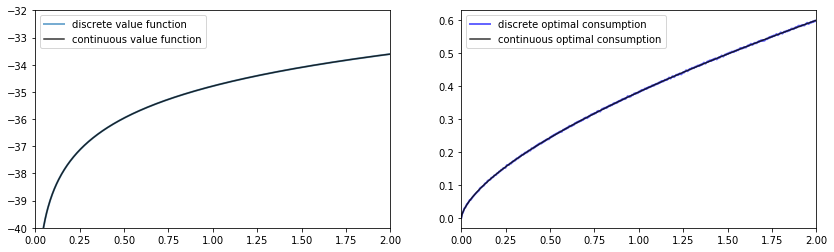

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].set_ylim(-40, -32)
ax[0].set_xlim(grid[0], grid[-1])
ax[1].set_xlim(grid[0], grid[-1])

lb0 = 'discrete value function'
ax[0].plot(grid, v, lw=2, alpha=0.6, label=lb0)

lb0 = 'continuous value function'
ax[0].plot(grid, v_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb0)
ax[0].legend(loc='upper left')

lb1 = 'discrete optimal consumption'
ax[1].plot(grid, c, 'b-', lw=2, alpha=0.6, label=lb1)

lb1 = 'continuous optimal consumption'
ax[1].plot(grid, c_star(grid), 'k-', lw=1.5, alpha=0.8, label=lb1)
ax[1].legend(loc='upper left')
plt.show()

The outcomes appear very close to those of the continuous version

Except for the “boundary” point, the value functions are very close:

In [24]:
np.abs(v - v_star(grid)).max()

121.49819147053378

In [25]:
np.abs(v - v_star(grid))[1:].max()

0.012681735127500815

The optimal consumption functions are close as well:

In [26]:
np.abs(c - c_star(grid)).max()

0.003826523100010082

In fact, the optimal consumption obtained in the discrete version is not
really monotone, but the decrements are quit small:

In [27]:
diff = np.diff(c)
(diff >= 0).all()

False

In [28]:
dec_ind = np.where(diff < 0)[0]
len(dec_ind)

174

In [29]:
np.abs(diff[dec_ind]).max()

0.001961853339766839

The value function is monotone:

In [30]:
(np.diff(v) > 0).all()

True

### Comparison of the solution methods

Let us solve the problem by the other two methods

#### Value iteration

In [31]:
ddp.epsilon = 1e-4
ddp.max_iter = 500
res1 = ddp.solve(method='value_iteration')
res1.num_iter

294

In [32]:
np.array_equal(σ, res1.sigma)

True

#### Modified policy iteration

In [33]:
res2 = ddp.solve(method='modified_policy_iteration')
res2.num_iter

16

In [34]:
np.array_equal(σ, res2.sigma)

True

#### Speed comparison

```ipython3
%timeit ddp.solve(method='value_iteration')
%timeit ddp.solve(method='policy_iteration')
%timeit ddp.solve(method='modified_policy_iteration')
```


As is often the case, policy iteration and modified policy iteration are
much faster than value iteration

### Replication of the figures

Using `DiscreteDP` we replicate the figures shown in the lecture

#### Convergence of value iteration

Let us first visualize the convergence of the value iteration algorithm
as in the lecture, where we use `ddp.bellman_operator` implemented as
a method of `DiscreteDP`

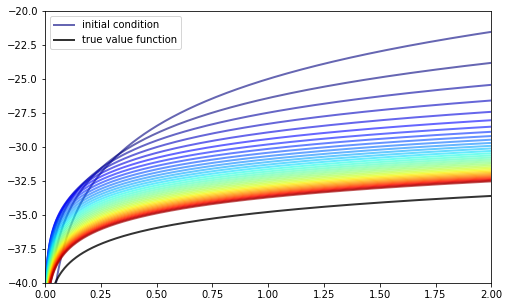

In [35]:
w = 5 * np.log(grid) - 25  # Initial condition
n = 35
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-40, -20)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = ddp.bellman_operator(w)
    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='upper left')

plt.show()

We next plot the consumption policies along the value iteration

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            5.518e+00      1.756e-03         
2            4.070e+00      2.648e-03         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            5.518e+00      7.966e-04         
2            4.070e+00      1.533e-03         
3            3.866e+00      2.386e-03         
4            3.673e+00      3.116e-03         
Iteration    Distance       Elapsed (seconds)
---------------------------------------------
1            5.518e+00      9.749e-04         
2            4.070e+00      1.837e-03         
3            3.866e+00      2.573e-03         
4            3.673e+00      3.304e-03         
5            3.489e+00      4.033e-03         
6            3.315e+00      4.758e-03         


/home/quantecon/anaconda3/lib/python3.7/site-packages/quantecon/compute_fp.py:152: RuntimeWarning: max_iter attained before convergence in compute_fixed_point
  warnings.warn(_non_convergence_msg, RuntimeWarning)


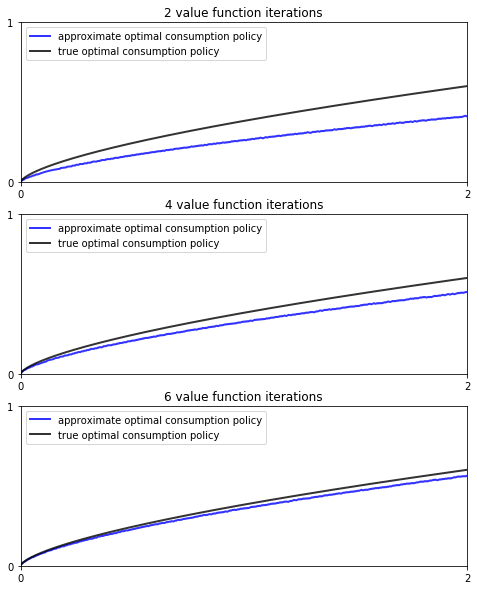

In [36]:
w = 5 * u(grid) - 25           # Initial condition

fig, ax = plt.subplots(3, 1, figsize=(8, 10))
true_c = c_star(grid)

for i, n in enumerate((2, 4, 6)):
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 2)
    ax[i].set_yticks((0, 1))
    ax[i].set_xticks((0, 2))

    w = 5 * u(grid) - 25       # Initial condition
    compute_fixed_point(ddp.bellman_operator, w, max_iter=n, print_skip=1)
    σ = ddp.compute_greedy(w)  # Policy indices
    c_policy = f(grid) - grid[σ]

    ax[i].plot(grid, c_policy, 'b-', lw=2, alpha=0.8,
               label='approximate optimal consumption policy')
    ax[i].plot(grid, true_c, 'k-', lw=2, alpha=0.8,
               label='true optimal consumption policy')
    ax[i].legend(loc='upper left')
    ax[i].set_title(f'{n} value function iterations')
plt.show()

#### Dynamics of the capital stock

Finally, let us work on [Exercise
2](https://lectures.quantecon.org/py/optgrowth.html#exercise-1), where we plot
the trajectories of the capital stock for three different discount
factors, $ 0.9 $, $ 0.94 $, and $ 0.98 $, with initial
condition $ k_0 = 0.1 $

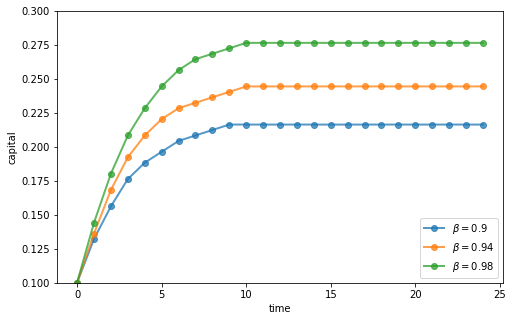

In [37]:
discount_factors = (0.9, 0.94, 0.98)
k_init = 0.1

# Search for the index corresponding to k_init
k_init_ind = np.searchsorted(grid, k_init)

sample_size = 25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel("time")
ax.set_ylabel("capital")
ax.set_ylim(0.10, 0.30)

# Create a new instance, not to modify the one used above
ddp0 = DiscreteDP(R, Q, β, s_indices, a_indices)

for beta in discount_factors:
    ddp0.beta = beta
    res0 = ddp0.solve()
    k_path_ind = res0.mc.simulate(init=k_init_ind, ts_length=sample_size)
    k_path = grid[k_path_ind]
    ax.plot(k_path, 'o-', lw=2, alpha=0.75, label=f'$\\beta = {beta}$')

ax.legend(loc='lower right')
plt.show()


<a id='ddp-algorithms'></a>

## Appendix: Algorithms

This appendix covers the details of the solution algorithms implemented for `DiscreteDP`

We will make use of the following notions of approximate optimality:

- For $ \varepsilon > 0 $, $ v $ is called an  $ \varepsilon $-approximation of $ v^* $ if $ \lVert v - v^*\rVert < \varepsilon $  
- A policy $ \sigma \in \Sigma $ is called $ \varepsilon $-optimal if $ v_{\sigma} $ is an $ \varepsilon $-approximation of $ v^* $  

### Value Iteration

The `DiscreteDP` value iteration method implements value function iteration as
follows

1. Choose any $ v^0 \in \mathbb{R}^n $, and specify $ \varepsilon > 0 $; set $ i = 0 $  
1. Compute $ v^{i+1} = T v^i $  
1. If $ \lVert v^{i+1} - v^i\rVert <  [(1 - \beta) / (2\beta)] \varepsilon $,
  then go to step 4; otherwise, set $ i = i + 1 $ and go to step 2  
1. Compute a $ v^{i+1} $-greedy policy $ \sigma $, and return $ v^{i+1} $ and $ \sigma $  


Given $ \varepsilon > 0 $, the value iteration algorithm

- terminates in a finite number of iterations  
- returns an $ \varepsilon/2 $-approximation of the optimal value function and an $ \varepsilon $-optimal policy function (unless `iter_max` is reached)  


(While not explicit, in the actual implementation each algorithm is
terminated if the number of iterations reaches `iter_max`)

### Policy Iteration

The `DiscreteDP` policy iteration method runs as follows

1. Choose any $ v^0 \in \mathbb{R}^n $ and compute a $ v^0 $-greedy policy $ \sigma^0 $; set $ i = 0 $  
1. Compute the value $ v_{\sigma^i} $ by solving
  the equation $ v = T_{\sigma^i} v $  
1. Compute a $ v_{\sigma^i} $-greedy policy
  $ \sigma^{i+1} $; let $ \sigma^{i+1} = \sigma^i $ if
  possible  
1. If $ \sigma^{i+1} = \sigma^i $, then return $ v_{\sigma^i} $
  and $ \sigma^{i+1} $; otherwise, set $ i = i + 1 $ and go to
  step 2  


The policy iteration algorithm terminates in a finite number of
iterations

It returns an optimal value function and an optimal policy function (unless `iter_max` is reached)

### Modified Policy Iteration

The `DiscreteDP` modified policy iteration method runs as follows:

1. Choose any $ v^0 \in \mathbb{R}^n $, and specify $ \varepsilon > 0 $ and $ k \geq 0 $; set $ i = 0 $  
1. Compute a $ v^i $-greedy policy $ \sigma^{i+1} $; let $ \sigma^{i+1} = \sigma^i $ if possible (for $ i \geq 1 $)  
1. Compute $ u = T v^i $ ($ = T_{\sigma^{i+1}} v^i $). If $ \mathrm{span}(u - v^i) < [(1 - \beta) / \beta] \varepsilon $, then go to step 5; otherwise go to step 4  
  - Span is defined by $ \mathrm{span}(z) = \max(z) - \min(z) $  
1. Compute $ v^{i+1} = (T_{\sigma^{i+1}})^k u $ ($ = (T_{\sigma^{i+1}})^{k+1} v^i $); set $ i = i + 1 $ and go to step 2  
1. Return $ v = u + [\beta / (1 - \beta)] [(\min(u - v^i) + \max(u - v^i)) / 2] \mathbf{1} $ and $ \sigma_{i+1} $  


Given $ \varepsilon > 0 $, provided that $ v^0 $ is such that
$ T v^0 \geq v^0 $, the modified policy iteration algorithm
terminates in a finite number of iterations

It returns an $ \varepsilon/2 $-approximation of the optimal value function and an $ \varepsilon $-optimal policy function (unless `iter_max` is reached)

See also the documentation for `DiscreteDP`